<a href="https://www.kaggle.com/code/saadyaqine/titanic-competition?scriptVersionId=257573839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


train_df=pd.read_csv('/kaggle/input/titanic/train.csv')
test_df=pd.read_csv('/kaggle/input/titanic/test.csv')
print(train_df.head())



   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
print(train_df.info(),train_df['Cabin'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
missing_data=pd.DataFrame({
    "Nombre_manquant": train_df.isnull().sum(),
    "Pourcentage %": (train_df.isnull().sum()/ len(train_df))*100
})
missing_data=missing_data[missing_data['Nombre_manquant']>0].sort_values("Nombre_manquant",ascending=False)
print("Résumé des valeurs manquantes")
if len(missing_data)>0:
    print(missing_data)
else :
    print("Aucune valeur manquante")

Résumé des valeurs manquantes
          Nombre_manquant  Pourcentage %
Cabin                 687      77.104377
Age                   177      19.865320
Embarked                2       0.224467


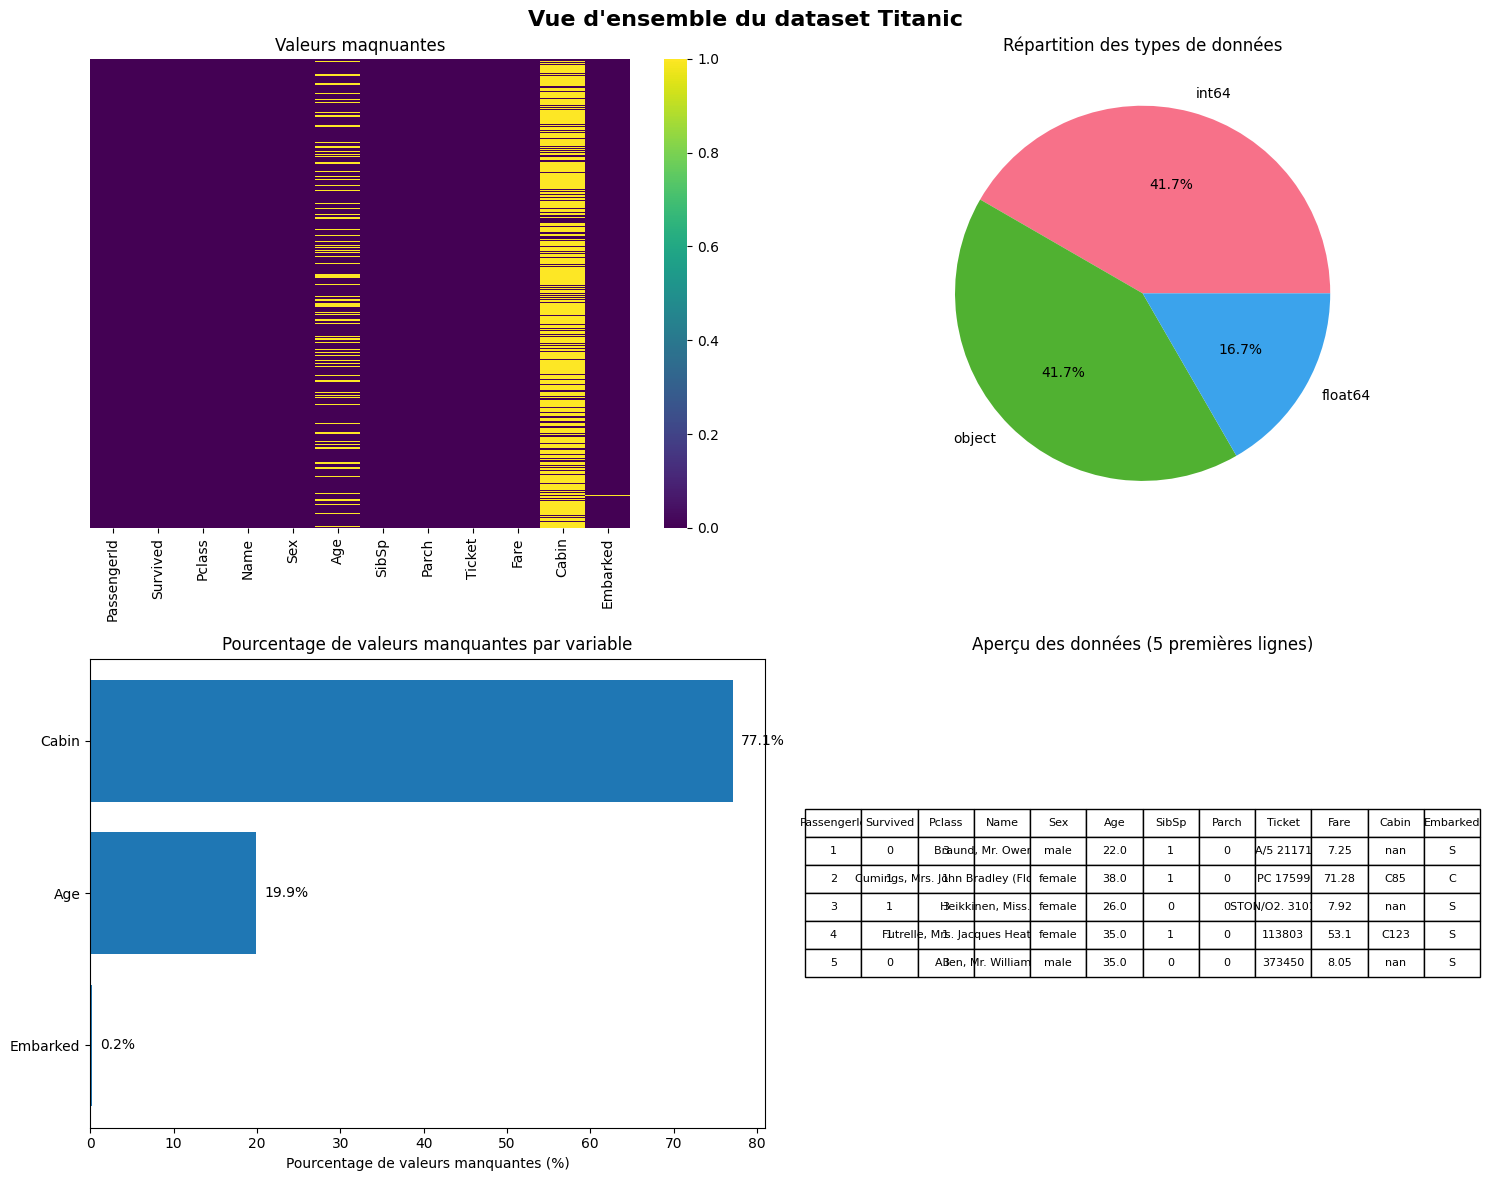

In [6]:
#Visualisations
fig,axes=plt.subplots(2,2,figsize=(15,12))
fig.suptitle("Vue d\'ensemble du dataset Titanic", fontsize=16,fontweight='bold')
#Heatmap des valeurs manquantes

if len(missing_data)>0:
    sns.heatmap(train_df.isnull(),
               yticklabels=False,
               cbar=True,
               cmap="viridis",
               ax=axes[0,0])
    axes[0,0].set_title("Valeurs maqnuantes")
else:
    axes[0,0].text(0.5, 0.5, 'Aucune valeur manquante', 
                   ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Valeurs manquantes')

#Distribution des types de données
data_types=train_df.dtypes.value_counts()
colors=sns.color_palette("husl", len(data_types))
axes[0,1].pie(data_types.values, labels=data_types.index, autopct='%1.1f%%', colors=colors)
axes[0,1].set_title('Répartition des types de données')

#Valeurs manquantes par colonne (barplot)
if len(missing_data)>0:
    missing_data_plot=missing_data.sort_values("Pourcentage %")
    bars = axes[1,0].barh(missing_data_plot.index, missing_data_plot['Pourcentage %'])
    axes[1,0].set_xlabel('Pourcentage de valeurs manquantes (%)')
    axes[1,0].set_title('Pourcentage de valeurs manquantes par variable')
    
    # Ajouter les valeurs sur les barres
    for i, (idx, row) in enumerate(missing_data_plot.iterrows()):
        axes[1,0].text(row['Pourcentage %'] + 1, i, f"{row['Pourcentage %']:.1f}%", 
                      va='center')
else:
    axes[1,0].text(0.5, 0.5, 'Aucune valeur manquante', 
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Valeurs manquantes par variable')
    
#Aperçu des premièreslignes sous formes de tableau 
axes[1,1].axis('tight')
axes[1,1].axis('off')
table_data = train_df.head().round(2)
table = axes[1,1].table(cellText=table_data.values,
                       colLabels=table_data.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
axes[1,1].set_title('Aperçu des données (5 premières lignes)')
plt.tight_layout()
plt.show()

In [7]:
print(f"""
    Résumé:
    {train_df.shape[0]} Passagers dans le dataset d'entrainement,
    {train_df.shape[1]} variables disponibles,
    Variables manquantes : {len(missing_data)},
    Taux de survie globale : {train_df["Survived"].mean():.1f}%
    """)


    Résumé:
    891 Passagers dans le dataset d'entrainement,
    12 variables disponibles,
    Variables manquantes : 3,
    Taux de survie globale : 0.4%
    


In [8]:
#Vérification de la cohérance des données

print("Cohérance des données")
print(f"Ages négatifs: {(train_df['Age']<0).sum()}")
print(f" Tarifs négatifs: {(train_df['Fare']<0).sum()}")
print(f"Classes valides (1,2,3): {train_df['Pclass'].isin([1,2,3]).all()}")
print(f"Valeurs de survie valides (0,1): {train_df['Survived'].isin([0,1])}")

Cohérance des données
Ages négatifs: 0
 Tarifs négatifs: 0
Classes valides (1,2,3): True
Valeurs de survie valides (0,1): 0      True
1      True
2      True
3      True
4      True
       ... 
886    True
887    True
888    True
889    True
890    True
Name: Survived, Length: 891, dtype: bool


In [9]:
from scipy import stats

plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize']=(15,10)

def survival_rate_by_category(df,column):
    survival_stats=df.groupby(column)["Survived"].agg(['count','sum','mean']).round(2)
    survival_stats.columns=['Total','Survivants',"Taux_survie"]
    survival_stats['Taux_Survie_Pct']=(survival_stats['Taux_survie']*100).round(1)
    return survival_stats.sort_values('Taux_survie', ascending=False)

In [10]:
def test_all_categorical_variables(df):

    variables_cat=["Sex",'Pclass',"Embarked"]
    results=[]

    for var in variables_cat:

        #Table de contingence
        contingency_table=pd.crosstab(df[var],df['Survived'])
        chi2,p_value=stats.chi2_contingency(contingency_table)[:2]
        is_significant= p_value < 0.05
        print(f"📈 Chi² = {chi2:.4f}")
        print(f"📈 p-value = {p_value:.2e}")
        print(f"📈 Significatif: {'✅ OUI' if is_significant else '❌ NON'}")

        survival_stats=survival_rate_by_category(df,var)
        print(f"📊 Taux de survie par catégorie:")
        print(survival_stats[['Taux_Survie_Pct']])

        results.append({
            "Variable":var,
            "Chi2": chi2,
            "p_value":p_value,
            "Significatif":is_significant
        })
    return pd.DataFrame(results)

In [11]:
cat_results = test_all_categorical_variables(train_df)

📈 Chi² = 260.7170
📈 p-value = 1.20e-58
📈 Significatif: ✅ OUI
📊 Taux de survie par catégorie:
        Taux_Survie_Pct
Sex                    
female             74.0
male               19.0
📈 Chi² = 102.8890
📈 p-value = 4.55e-23
📈 Significatif: ✅ OUI
📊 Taux de survie par catégorie:
        Taux_Survie_Pct
Pclass                 
1                  63.0
2                  47.0
3                  24.0
📈 Chi² = 26.4891
📈 p-value = 1.77e-06
📈 Significatif: ✅ OUI
📊 Taux de survie par catégorie:
          Taux_Survie_Pct
Embarked                 
C                    55.0
Q                    39.0
S                    34.0


In [12]:
def test_numerical_variables(df):

    numerical_variables=['Age', 'SibSp','Parch','Fare']
    results=[]

    for var in numerical_variables:

        if var in df.columns and df[var].notna().sum() >0:
            print(f"\n📈 Test pour {var}:")
            group_deceased= df[df['Survived']==0][var].dropna()
            group_survived=df[df['Survived']==1][var].dropna()

            print(f"Décédés: moyenne= {group_deceased.mean():.3f}")
            print(f"Survivants: moyenne= {group_survived.mean():.3f}")
            print(f"Différence: {group_survived.mean()- group_deceased.mean():.3f}")

            t_stat,p_value=stats.ttest_ind(group_deceased,group_survived)

            correlation=df[[var,'Survived']].corr().iloc[0,1]
            is_significant=p_value < 0.05

            print(f"📈 t-statistic = {t_stat:.4f}")
            print(f"📈 p-value = {p_value:.2e}")
            print(f"📈 Corrélation = {correlation:.4f}")
            print(f"📈 Significatif: {'✅ OUI' if is_significant else '❌ NON'}")
            
            results.append({
                'Variable': var,
                'T_statistic': t_stat,
                'p_value': p_value,
                'Correlation': correlation,
                'Significatif': is_significant
            })
    
    return pd.DataFrame(results)                         

In [13]:
num_results = test_numerical_variables(train_df)


📈 Test pour Age:
Décédés: moyenne= 30.626
Survivants: moyenne= 28.344
Différence: -2.282
📈 t-statistic = 2.0667
📈 p-value = 3.91e-02
📈 Corrélation = -0.0772
📈 Significatif: ✅ OUI

📈 Test pour SibSp:
Décédés: moyenne= 0.554
Survivants: moyenne= 0.474
Différence: -0.080
📈 t-statistic = 1.0538
📈 p-value = 2.92e-01
📈 Corrélation = -0.0353
📈 Significatif: ❌ NON

📈 Test pour Parch:
Décédés: moyenne= 0.330
Survivants: moyenne= 0.465
Différence: 0.135
📈 t-statistic = -2.4420
📈 p-value = 1.48e-02
📈 Corrélation = 0.0816
📈 Significatif: ✅ OUI

📈 Test pour Fare:
Décédés: moyenne= 22.118
Survivants: moyenne= 48.395
Différence: 26.278
📈 t-statistic = -7.9392
📈 p-value = 6.12e-15
📈 Corrélation = 0.2573
📈 Significatif: ✅ OUI


In [14]:
def simple_feature_selection(df):

    #Tests catégorielles 
    cat_results=test_all_categorical_variables(df)

    #Tests numériques
    num_results=test_numerical_variables(df)

    selected_cat=cat_results[cat_results['Significatif']]['Variable'].tolist()
    selected_num=num_results[num_results['Significatif']]['Variable'].tolist()
    
    all_selected=selected_cat + selected_num

    rejected_cat=cat_results[~cat_results['Significatif']]['Variable'].tolist()
    rejected_num=num_results[~num_results['Significatif']]['Variable'].tolist()

    all_rejected=rejected_cat + rejected_num
    
    print(f"\n✅ FEATURES SÉLECTIONNÉES ({len(all_selected)}):")
    print("Variables catégorielles:")
    for var in selected_cat:
        p_val = cat_results[cat_results['Variable'] == var]['p_value'].iloc[0]
        print(f"  • {var}: p = {p_val:.2e}")
    
    print("Variables numériques:")
    for var in selected_num:
        p_val = num_results[num_results['Variable'] == var]['p_value'].iloc[0]
        corr = num_results[num_results['Variable'] == var]['Correlation'].iloc[0]
        print(f"  • {var}: p = {p_val:.2e}, corr = {corr:.3f}")
    
    if all_rejected:
        print(f"\n❌ FEATURES REJETÉES ({len(all_rejected)}):")
        for var in all_rejected:
            print(f"  • {var}")
    
    print(f"\n📊 RÉSUMÉ:")
    print(f"• Variables testées: {len(all_selected) + len(all_rejected)}")
    print(f"• Variables sélectionnées: {len(all_selected)}")
    print(f"• Taux de sélection: {len(all_selected)/(len(all_selected) + len(all_rejected)):.1%}")
    
    return {
        'selected_features': all_selected,
        'rejected_features': all_rejected,
        'categorical_results': cat_results,
        'numerical_results': num_results
    }
    print(f"\n✅ FEATURES SÉLECTIONNÉES ({len(all_selected)}):")
    print("Variables catégorielles:")
    for var in selected_cat:
        p_val = cat_results[cat_results['Variable'] == var]['p_value'].iloc[0]
        print(f"  • {var}: p = {p_val:.2e}")
    
    print("Variables numériques:")
    for var in selected_num:
        p_val = num_results[num_results['Variable'] == var]['p_value'].iloc[0]
        corr = num_results[num_results['Variable'] == var]['Correlation'].iloc[0]
        print(f"  • {var}: p = {p_val:.2e}, corr = {corr:.3f}")
    
    if all_rejected:
        print(f"\n❌ FEATURES REJETÉES ({len(all_rejected)}):")
        for var in all_rejected:
            print(f"  • {var}")
    
    print(f"\n📊 RÉSUMÉ:")
    print(f"• Variables testées: {len(all_selected) + len(all_rejected)}")
    print(f"• Variables sélectionnées: {len(all_selected)}")
    print(f"• Taux de sélection: {len(all_selected)/(len(all_selected) + len(all_rejected)):.1%}")
    
    return {
        'selected_features': all_selected,
        'rejected_features': all_rejected,
        'categorical_results': cat_results,
        'numerical_results': num_results
    }

    

In [15]:
final_results = simple_feature_selection(train_df)
selected_features = final_results['selected_features']

📈 Chi² = 260.7170
📈 p-value = 1.20e-58
📈 Significatif: ✅ OUI
📊 Taux de survie par catégorie:
        Taux_Survie_Pct
Sex                    
female             74.0
male               19.0
📈 Chi² = 102.8890
📈 p-value = 4.55e-23
📈 Significatif: ✅ OUI
📊 Taux de survie par catégorie:
        Taux_Survie_Pct
Pclass                 
1                  63.0
2                  47.0
3                  24.0
📈 Chi² = 26.4891
📈 p-value = 1.77e-06
📈 Significatif: ✅ OUI
📊 Taux de survie par catégorie:
          Taux_Survie_Pct
Embarked                 
C                    55.0
Q                    39.0
S                    34.0

📈 Test pour Age:
Décédés: moyenne= 30.626
Survivants: moyenne= 28.344
Différence: -2.282
📈 t-statistic = 2.0667
📈 p-value = 3.91e-02
📈 Corrélation = -0.0772
📈 Significatif: ✅ OUI

📈 Test pour SibSp:
Décédés: moyenne= 0.554
Survivants: moyenne= 0.474
Différence: -0.080
📈 t-statistic = 1.0538
📈 p-value = 2.92e-01
📈 Corrélation = -0.0353
📈 Significatif: ❌ NON

📈 Test pour Par

In [16]:
def prepare_selected_features(df,selected_features):
    print(f"Features sélectionnées à utiliser :{selected_features}")
    
    data=df.copy()

    #Age - Imputation par la médianne

    if 'Age' in selected_features:
        median_age=data['Age'].median()
        data['Age'].fillna(median_age,inplace=True)


    #Embarked - Imputation par la valeur la plus fréquente

    if 'Embarked' in selected_features:
        freq_embarked=data['Embarked'].mode()[0]
        data['Embarked'].fillna(freq_embarked,inplace=True)

    #Fare - Imputation par la moyenne 
    if 'Fare' in selected_features:
        median_fare=data['Fare'].median()
        data['Fare'].fillna(median_fare,inplace=True)

    data_encoded=data.copy()
    encoders={}
    cat_features=[f for f in selected_features if data[f].dtype=='object']
    for feature in cat_features:
        if feature in data_encoded.columns:
            le=LabelEncoder()
            data_encoded[feature]= le.fit_transform(data_encoded[feature].astype('str'))
            encoders[feature]=le

    X=data_encoded[selected_features]
    y=data_encoded['Survived']
    print(f"\\n✅ Données préparées:")
    print(f"  • Shape: {X.shape}")
    print(f"  • Features: {list(X.columns)}")
    print(f"  • Valeurs manquantes restantes: {X.isnull().sum().sum()}")
    
    return X, y, encoders

    
    
    

In [17]:
X,y,encoders=prepare_selected_features(train_df,selected_features)

Features sélectionnées à utiliser :['Sex', 'Pclass', 'Embarked', 'Age', 'Parch', 'Fare']
\n✅ Données préparées:
  • Shape: (891, 6)
  • Features: ['Sex', 'Pclass', 'Embarked', 'Age', 'Parch', 'Fare']
  • Valeurs manquantes restantes: 0


In [18]:
def evaluate_models(X,y,cv_folds=5):

    models={
        'Logistic Regression':LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42,n_estimators=1000,max_depth=5,min_samples_split=10),
        'XGBoost': XGBClassifier(random_state=42,n_estimators=100,verbosity=0,use_label_encoder=False)
    }

    skf=StratifiedKFold(n_splits=cv_folds,shuffle=True,random_state=42)

    results={}

    for model_name,model in models.items():
        print(f"Entrainement {model_name}")
        cross_scores=cross_val_score(model,X,y,cv=skf,scoring='accuracy')
        cross_roc_scores=cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
        results['model_name']={
            'accuracy_scores': cross_scores,
            'accuracy_mean': cross_scores.mean(),
            'accuracy_std': cross_scores.std(),
            'roc_auc_scores': cross_roc_scores,
            'roc_auc_mean': cross_roc_scores.mean(),
            'roc_auc_std': cross_roc_scores.std()
                        
        }
        
        print(f"  📈 Accuracy: {cross_scores.mean():.4f} (±{cross_scores.std():.4f})")
        print(f"  📈 ROC-AUC: {cross_roc_scores.mean():.4f} (±{cross_roc_scores.std():.4f})")
    
    return results
        

In [19]:
evaluate_models(X,y,cv_folds=5)

Entrainement Logistic Regression
  📈 Accuracy: 0.7901 (±0.0189)
  📈 ROC-AUC: 0.8495 (±0.0212)
Entrainement Random Forest
  📈 Accuracy: 0.8260 (±0.0126)
  📈 ROC-AUC: 0.8708 (±0.0241)
Entrainement XGBoost
  📈 Accuracy: 0.8204 (±0.0251)
  📈 ROC-AUC: 0.8775 (±0.0244)


{'model_name': {'accuracy_scores': array([0.84916201, 0.82022472, 0.7752809 , 0.82022472, 0.83707865]),
  'accuracy_mean': 0.8203941999874459,
  'accuracy_std': 0.025064817069177202,
  'roc_auc_scores': array([0.90790514, 0.89792781, 0.84197861, 0.85855615, 0.88113283]),
  'roc_auc_mean': 0.8775001066532425,
  'roc_auc_std': 0.02439509718394689}}

In [20]:
def prepare_test_data(df,selected_features):
    print(f"Features sélectionnées à utiliser :{selected_features}")
    
    data=df.copy()

    #Age - Imputation par la médianne

    if 'Age' in selected_features:
        median_age=data['Age'].median()
        data['Age'].fillna(median_age,inplace=True)


    #Embarked - Imputation par la valeur la plus fréquente

    if 'Embarked' in selected_features:
        freq_embarked=data['Embarked'].mode()[0]
        data['Embarked'].fillna(freq_embarked,inplace=True)

    #Fare - Imputation par la moyenne 
    if 'Fare' in selected_features:
        median_fare=data['Fare'].median()
        data['Fare'].fillna(median_fare,inplace=True)

    data_encoded=data.copy()
    encoders={}
    cat_features=[f for f in selected_features if data[f].dtype=='object']
    for feature in cat_features:
        if feature in data_encoded.columns:
            le=LabelEncoder()
            data_encoded[feature]= le.fit_transform(data_encoded[feature].astype('str'))
            encoders[feature]=le

    X=data_encoded[selected_features]
    
    print(f"\\n✅ Données préparées:")
    print(f"  • Shape: {X.shape}")
    print(f"  • Features: {list(X.columns)}")
    print(f"  • Valeurs manquantes restantes: {X.isnull().sum().sum()}")
    
    return X

    
    
    

In [21]:
best_model=RandomForestClassifier(random_state=42,n_estimators=1000,max_depth=5,min_samples_split=10)
X_train,y_train,encoders=prepare_selected_features(train_df,selected_features)
best_model.fit(X,y)
X_test=prepare_test_data(test_df,selected_features)

predictions=best_model.predict(X_test)

submission=pd.DataFrame({
    'PassengerId':test_df['PassengerId'],
    'Survived': predictions
}
)
submission.to_csv('submission_baseline',index=False)

Features sélectionnées à utiliser :['Sex', 'Pclass', 'Embarked', 'Age', 'Parch', 'Fare']
\n✅ Données préparées:
  • Shape: (891, 6)
  • Features: ['Sex', 'Pclass', 'Embarked', 'Age', 'Parch', 'Fare']
  • Valeurs manquantes restantes: 0
Features sélectionnées à utiliser :['Sex', 'Pclass', 'Embarked', 'Age', 'Parch', 'Fare']
\n✅ Données préparées:
  • Shape: (418, 6)
  • Features: ['Sex', 'Pclass', 'Embarked', 'Age', 'Parch', 'Fare']
  • Valeurs manquantes restantes: 0


In [22]:
submission['Survived'].value_counts()

Survived
0    286
1    132
Name: count, dtype: int64